## **Gaussian Process Campaign**

This notebook contains basic working examples of fitting and running inference using Gaussian Processes (GPs) as the base estimator model in `twinLab`. 

An in-depth introductory review of GPs can be found at [Rasmussen and Williams (2006)](https://gaussianprocess.org/gpml/). 

This notebook will cover:
- Basic syntax
- Detrending data
- Specifying a covarance module

In [12]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# twinLab import
import twinlab as tl

### **Problem Formulation**
As a start, we will solve a simple regression problem with one input and one output. 

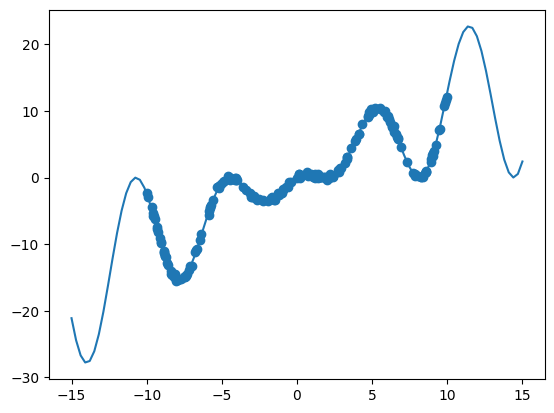

In [13]:
# The true function
def oscillator(x):
    return np.cos((x - 5) / 2) ** 2 * x * 2
    # return 3*np.exp(-x) * np.sin(2*np.pi*x)

X = np.linspace(-15,15,100)[:,np.newaxis]
y = oscillator(X) # Arrange outputs as feature columns

n_data = 200
X_data = np.random.uniform(-10, 10, size=n_data)
y_data = oscillator(X_data) + np.random.normal(scale=0.2, size=X_data.shape)

plt.plot(X,y)
plt.scatter(X_data, y_data)
plt.show()

The `Campaign` class assumes that data coming in and out are presented as `pandas.DataFrame` objects with clearly labelled columns. Here, we will label the input (predictor) variable `x` and the output variable `y`.

In `twinlab`, data is expected to be in column-feature format, meaning each row represents a single data sample, and each column represents a data feature. 

In [14]:
# Convert to dataframes
df = pd.DataFrame({'x': X_data, 'y': y_data})
df.head()

,x,y
0,-4.040103,-0.333347
1,2.202231,0.099167
2,-0.021112,-0.023145
3,1.613974,0.015534
4,2.207928,0.499191


In [15]:
# Upload dataframe
dataset_id = "BasicGP_Data"

tl.upload_dataset(df, dataset_id, verbose=True)

Dataframe is uploading.
Processing dataset.
Dataset BasicGP_Data was processed.


### **Basic Campaign Workflow**

By default, a `Campaign` object will try to fit a Gaussian Process with a Constant Mean and a Matern 5/2 covariance kernel to the data. This is done with the basic syntax shown below. 

**Note**: the `train_test_ratio` parameter determines how many data samples in `df` to use for fitting the model. E.g. if `train_test_split=0.4`, then 40% of the samples in `df` are used for fitting, and the remaining data is used for testing. The data reserved for testing is used to assess the performance of the model. 

In [23]:
# Initialise campaign
campaign_id = "BasicGP"

campaign_params = {
    "dataset_id": dataset_id,                   # This points the campaign to the uploaded dataset
    "inputs": ["x"],                            # Using the datasets column headers define the input and output data
    "outputs": ["y"],
    "test_train_ratio": 0.75,                   # Determine how much data is used for training, here 75% is used to train the model  
    "estimator": "gaussian_process_regression", # and 25% is used to test it.
}                                        

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

Model BasicGP has begun training.
{'message': 'Could not deserialize remote exception due to local error:\nNo module named \'typeguard\'\nThis can happen if your local environment does not have the remote exception definitions.\nHere is the remote traceback:\nTraceback (most recent call last):\n  File "/pkg/modal/_container_entrypoint.py", line 352, in handle_input_exception\n    yield\n  File "/pkg/modal/_container_entrypoint.py", line 438, in run_inputs\n    res = imp_fun.fun(*args, **kwargs)\n  File "/root/functions.py", line 90, in train_model_cpu\n    return _train_model(campaign_path, campaign_dict, training_dict)\n  File "/root/functions.py", line 111, in _train_model\n    campaign.fit(**training_dict)\n  File "/twinLab/twinlab/campaign/campaign.py", line 127, in fit\n    def fit(\n  File "/usr/local/lib/python3.10/site-packages/typeguard/_functions.py", line 138, in check_argument_types\n    check_type_internal(value, annotation, memo)\n  File "/usr/local/lib/python3.10/site-pa

KeyError: 'job_complete not in API response body'

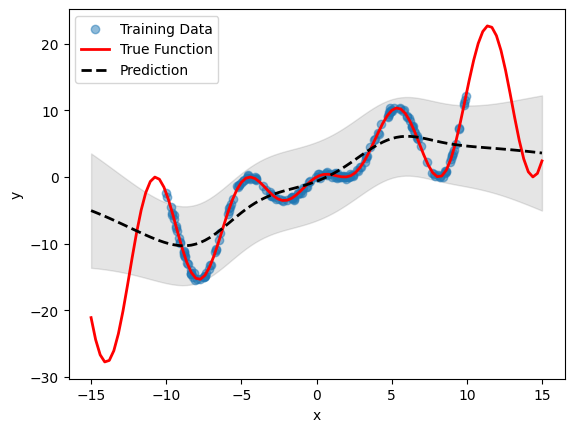

In [17]:
# Plot inference results
df_mean, df_stdev = tl.predict_campaign(pd.DataFrame(X, columns=["x"]), campaign_id)
y_mean, y_stdev = df_mean.values, df_stdev.values

plt.fill_between(X.flatten(), 
                 (y_mean - 1.96*y_stdev).flatten(), 
                 (y_mean + 1.96*y_stdev).flatten(), 
                 color='k', alpha=0.1)

plt.scatter(df['x'], df['y'], alpha=0.5, label='Training Data')
plt.xlabel('x'); plt.ylabel('y')

plt.plot(X, y, c='r', linewidth=2, label='True Function')
plt.plot(X, y_mean, c='k', linewidth=2, linestyle='dashed', label='Prediction')
plt.legend()
plt.show()

### **Detrending Data**

A standard data processing task before fitting a model to data is (linear) *detrending*: here, the linear non-stationary information about the data is subtracted from the data. This may help with subsequent model fitting. 

In `Campaign`, this is achieved simply with the keyword `detrend` provided to the `estimator_kwargs` dictionary during initialisation. This results in the following code:

In [18]:
# Initialise campaign
campaign_id = "DetrendingGP"

campaign_params = {
    "dataset_id": "BasicGP_Data",               # This points the campaign to the uploaded dataset
    "inputs": ["x"],                            # Using the datasets column headers define the input and output data
    "outputs": ["y"],
    "test_train_ratio": 0.75,                   # Determine how much data is used for training, here 75% is used to train the model  
    "estimator": "gaussian_process_regression", # and 25% is used to test it.
    'estimator_kwargs': {
        'detrend': True
    }
}                                        

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

Model DetrendingGP has begun training.


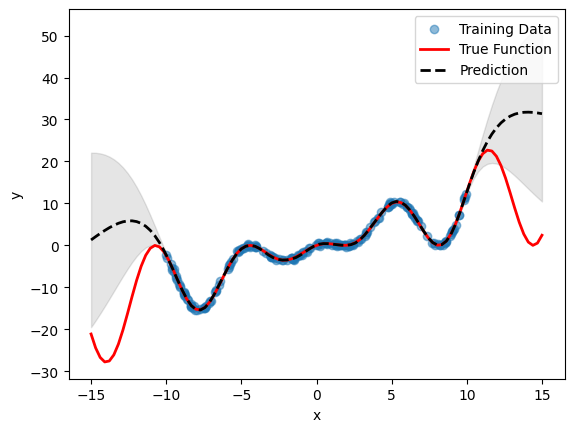

In [19]:
# Plot inference results
df_mean, df_stdev = tl.predict_campaign(pd.DataFrame(X, columns=["x"]), campaign_id)
y_mean, y_stdev = df_mean.values, df_stdev.values

plt.fill_between(X.flatten(), 
                 (y_mean - 1.96*y_stdev).flatten(), 
                 (y_mean + 1.96*y_stdev).flatten(), 
                 color='k', alpha=0.1)

plt.scatter(df['x'], df['y'], alpha=0.5, label='Training Data')
plt.xlabel('x'); plt.ylabel('y')

plt.plot(X, y, c='r', linewidth=2, label='True Function')
plt.plot(X, y_mean, c='k', linewidth=2, linestyle='dashed', label='Prediction')
plt.legend()
plt.show()

Note the difference in the mean prediction of the detrended model compared to the standard model without detrending (from the previous section). The prediction is automatically re-trended during inference, so no need for any other operations.

### **Specifying a Covariance Kernel**

In some cases, it may be desirable to specify a covariance module for the GP. The user may have some belief that the process is linear in nature, or may contain a combination of periodic signals at different length-scales, or may want to specifically account for short-time noise in the data. 

`Campaign` allows the user to do this, via the `covar_module` keyword provided to the `estimator_kwargs` dictionary. Currently, the kernels are provided as 3-character uppercase strings. The list of possible kernels are: 
- `"LIN"`: Linear kernel
- `"M12"`: Matern 1/2 kernel
- `"M32"`: Matern 3/2 kernel
- `"M52"`: Matern 5/2 kernel
- `"PER"`: Periodic kernel
- `"RBF"`: Radial Basis Function kernel
- `"RQF"`: Rational Quadratic Kernel

Additionally, the kernels can be [composed](https://www.cs.toronto.edu/~duvenaud/cookbook/) using brackets and `+` or `*` string operators. For example:
- `"LIN+PER"`
- `"(M52*PER)+RQF`

In [20]:
# Initialise campaign
campaign_id = "LinearGP"

campaign_params = {
    "dataset_id": "BasicGP_Data",               # This points the campaign to the uploaded dataset
    "inputs": ["x"],                            # Using the datasets column headers define the input and output data
    "outputs": ["y"],
    "test_train_ratio": 0.75,                   # Determine how much data is used for training, here 75% is used to train the model  
    "estimator": "gaussian_process_regression", # and 25% is used to test it.
    'estimator_kwargs': {
        'covar_module': "LIN"
    }
}                                        

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

Model LinearGP has begun training.


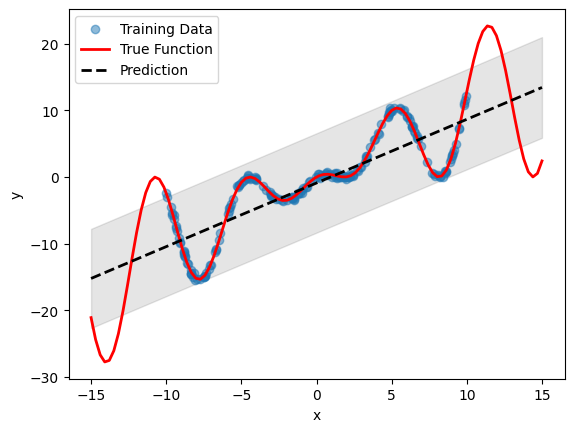

In [21]:
# Plot inference results
df_mean, df_stdev = tl.predict_campaign(pd.DataFrame(X, columns=["x"]), campaign_id)
y_mean, y_stdev = df_mean.values, df_stdev.values

plt.fill_between(X.flatten(), 
                 (y_mean - 1.96*y_stdev).flatten(), 
                 (y_mean + 1.96*y_stdev).flatten(), 
                 color='k', alpha=0.1)

plt.scatter(df['x'], df['y'], alpha=0.5, label='Training Data')
plt.xlabel('x'); plt.ylabel('y')

plt.plot(X, y, c='r', linewidth=2, label='True Function')
plt.plot(X, y_mean, c='k', linewidth=2, linestyle='dashed', label='Prediction')
plt.legend()
plt.show()

In [22]:
# Delete campaigns and dataset
tl.delete_campaign("BasicGP")
tl.delete_campaign("DetrendingGP")
tl.delete_campaign("LinearGP")

tl.delete_dataset(dataset_id)